In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split


In [5]:
train_df = pd.read_csv("traindata.csv")
test_df = pd.read_csv("testdata.csv")


In [ ]:
def preprocess(df):
    df = df.copy()
    df = df.drop(columns=["time_stamp", "product_name", "brand_name", "type"], errors="ignore")
    df = df.fillna("unknown")
    df["sellingprice"] = pd.to_numeric(df["sellingprice"], errors="coerce").fillna(0)
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [24]:
def feature_engineering(df, is_train=True):
    agg_funcs = {
        "sellingprice": ["mean", "sum", "max", "min", "count"],
        "user_action": lambda x: x.nunique(),
        "contentid": lambda x: x.nunique(),
        "brand_id": lambda x: x.nunique(),
        "product_gender": lambda x: x.mode()[0] if not x.mode().empty else "unknown",
        "Level1_Category_Name": lambda x: x.mode()[0] if not x.mode().empty else "unknown",
        "Level2_Category_Name": lambda x: x.mode()[0] if not x.mode().empty else "unknown",
        "Level3_Category_Name": lambda x: x.mode()[0] if not x.mode().empty else "unknown",
    }
    if is_train:
        agg_funcs["gender"] = "first"

    grouped = df.groupby("unique_id").agg(agg_funcs)
    grouped.columns = ["_".join(col) if isinstance(col, tuple) else col for col in grouped.columns]
    grouped.reset_index(inplace=True)
    return grouped

train_users = feature_engineering(train_df, is_train=True)
test_users = feature_engineering(test_df, is_train=False)

In [25]:
all_data = pd.concat([train_users.drop(columns=["gender_first"]), test_users], axis=0)
all_data = pd.get_dummies(all_data, columns=[
    "product_gender_<lambda>", "Level1_Category_Name_<lambda>",
    "Level2_Category_Name_<lambda>", "Level3_Category_Name_<lambda>"
])

X_train = all_data.iloc[:len(train_users), :]
X_test = all_data.iloc[len(train_users):, :]
y_train = train_users["gender_first"].map({"F": 0, "M": 1})
# Clean up feature names to avoid invalid characters for XGBoost
X_train.columns = X_train.columns.str.replace('[\\[\\]<>]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[\\[\\]<>]', '_', regex=True)

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train.drop(columns=["unique_id"]), y_train, 
                                            stratify=y_train, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, 
                          scale_pos_weight=(y_tr == 0).sum() / (y_tr == 1).sum(),
                           eval_metric='logloss')
model.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

conf = confusion_matrix(y_val, y_pred)
fnr = conf[1, 0] / (conf[1, 0] + conf[1, 1])
fpr = conf[0, 1] / (conf[0, 0] + conf[0, 1])
ber = (fnr + fpr) / 2
auc = roc_auc_score(y_val, y_proba)

print(f"Balanced Error Rate: {ber:.4f}")
print(f"ROC AUC: {auc:.4f}")
print(f"Custom Score: {(ber + (1 - auc)) / 2:.4f}")

Balanced Error Rate: 0.2406
ROC AUC: 0.8203
Custom Score: 0.2101


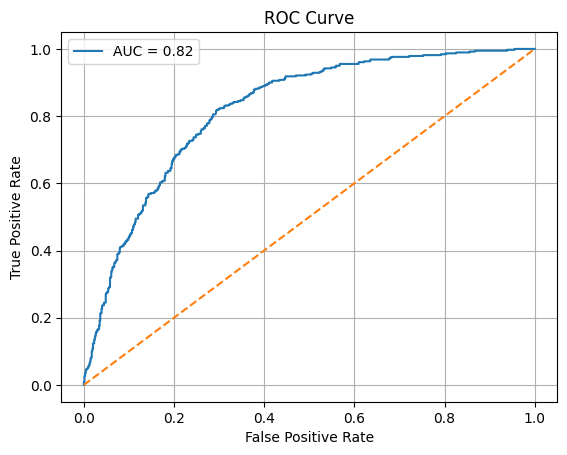

In [32]:
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [33]:
test_users["gender"] = model.predict(X_test.drop(columns=["unique_id"]))
test_users["gender"] = test_users["gender"].map({0: "F", 1: "M"})
test_users[["unique_id", "gender"]].to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv
